### Parkinson’s Disease Score Prediction

#### Load dataset

In [30]:
import pandas as pd

df_data = pd.read_csv('../datasets/parkinsons_updrs.csv')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   object 
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

-   The dataset has **5,875 entries** and **22 columns**.

    -   **No missing values** across all columns (`5875 non-null` for each).

    -   **Data types**:

    -   `subject` and `age`: `int64`

    -   `sex`: `object` (categorical, needs encoding)

    -   Remaining features: `float64` (numerical)

-   Since `sex` is a **categorical variable**, it needs to be encoded (e.g., label encoding or one-hot encoding) before feeding into the model.

    -   All medical voice measurement features are already numeric and ready for modeling.

#### Encode categorical variable

In [31]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Encode the 'sex' column and stored it in the new column
df_data['sex_encoded'] = encoder.fit_transform(df_data[['sex']])

# Check the encode category
print("Encoded categories:", encoder.categories_)


Encoded categories: [array(['female', 'male'], dtype=object)]


In [32]:
df_data[['sex', 'sex_encoded']]

,sex,sex_encoded
0,male,1.0
1,male,1.0
2,male,1.0
3,male,1.0
4,male,1.0
...,...,...
5870,male,1.0
5871,male,1.0
5872,male,1.0
5873,male,1.0


#### Visualizing Gender Distribution

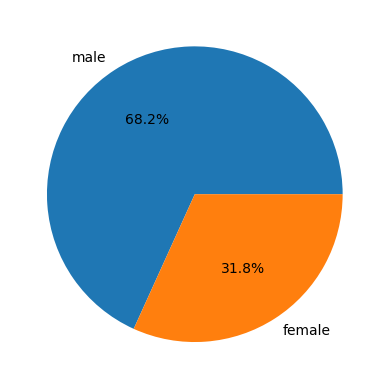

In [33]:
import matplotlib.pyplot as plt

# Count male and female
sex_counts = df_data['sex'].value_counts()

# Extract category names and values
sex_names = sex_counts.index.tolist()
sex_values = sex_counts.values.tolist()

# Create pie chart
plt.pie(sex_counts, autopct='%.1f%%', labels=sex_names)
plt.show()


We can further explore age distribution by gender to gain a deeper understanding of demographic patterns in the dataset.\
Since the dataset provides only sex and age columns, we must manually define age bins to categorize age into meaningful intervals.

Using the pandas.cut() function and groupby() method, we can create and analyze age groups by gender.

#### Group Age and Gender

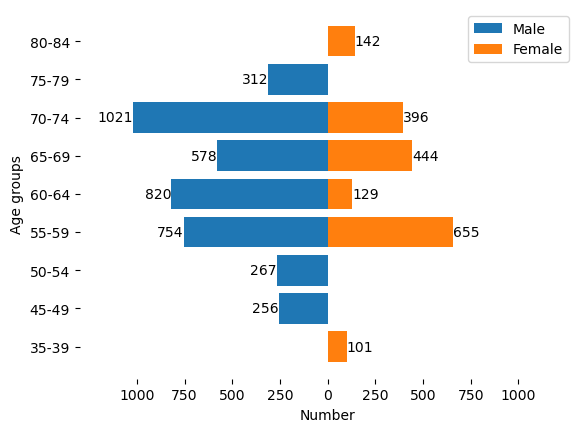

In [34]:
# Define age group bins and labels
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,60, 65, 70, 75, 80, 85, 90, float('inf')]
age_labels = ["0-4", "5-9", "10-14", "15-19", "20-24",
              "25-29", "30-34", "35-39", "40-44", "45-49",
              "50-54", "55-59", "60-64", "65-69", "70-74",
              "75-79", "80-84", "85-89", "90+"]

# Add new column 'age_group' to DataFrame
df_data['age_group'] = pd.cut(df_data['age'], bins=age_bins, labels=age_labels)

# Group by age group and sex, then count
df_population = df_data.groupby(['age_group', 'sex'], observed=False).size().unstack()

# Reset index and filter only age groups that have male and female data
df_population = df_population.reset_index()
df_population = df_population[(df_population['male'] != 0) | (df_population['female'] != 0)]

# Invert male counts for left side of plot
x_male = df_population['male'] * -1
x_female = df_population['female']
y = df_population['age_group']

# Create horizontal bar chart
fig, ax = plt.subplots()
ax1 = ax.barh(y, x_male, label='Male')
ax2 = ax.barh(y, x_female, label='Female')

# Add data labels to bars
ax.bar_label(ax1, labels=[f'{int(x)}' if x != 0 else '' for x in -ax1.datavalues])
ax.bar_label(ax2, labels=[f'{x}' if x != 0 else '' for x in ax2.datavalues])

# Remove border around chart
ax.set_frame_on(False)

# Set x-axis limits and ticks
ax.set_xlim(-1300, 1300)
ax.set_xticks([-1000, -750, -500, -250, 0, 250, 500, 750, 1000])
ax.set_xticklabels([1000, 750, 500, 250, 0, 250, 500, 750, 1000])

# Label axes
ax.set_xlabel('Number')
ax.set_ylabel('Age groups')

# Add legend
ax.legend()
plt.show()



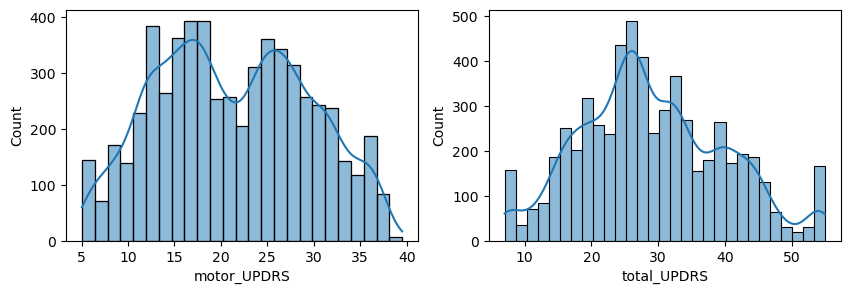

In [35]:
import seaborn as sns

# Define target feature names
x_feature_names = ['motor_UPDRS', 'total_UPDRS']

# Create 1 row × 2 column subplot layout
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Draw histograms with KDE overlay for each target variable
for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, kde=True, ax=ax)


-   The **left chart** shows the distribution of `motor_UPDRS`, with a noticeable peak around 20--25.

    -   The **right chart** shows `total_UPDRS`, which peaks slightly higher near 30--35.

    -   Both charts reveal that the target variables are **not perfectly symmetric**, suggesting potential benefits from further transformation or normalization in regression modeling.

#### Splitting the Dataset

In this example, we choose **19 features** as the model input variables and assign them to `X`. These include the participant's age, sex, test time, and 16 voice signal measurement features.

The **target outputs** are:

-   `motor_UPDRS`

-   `total_UPDRS`

These are placed in the variable `y`.

We use `train_test_split()` from **scikit-learn** to split `X` and `y` into training and testing sets based on a specified ratio.

In [36]:
from sklearn.model_selection import train_test_split

x_feature_names = ['age', 'sex_encoded', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 
                   'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 
                   'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 
                   'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

y_target_names = ['motor_UPDRS', 'total_UPDRS']

# Extract features and target variables
X = df_data[x_feature_names].values
y = df_data[y_target_names].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display dataset dimensions
print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)


Shape of training set X: (4112, 19)
Shape of testing set X: (1763, 19)


-   The training set contains **4112 records** (80%) for model learning.

    -   The testing set retains **1763 records** (20%) for evaluation.

    -   This split allows us to train the model on most of the data while reserving enough for validating its predictive power.

#### Build a Random Forest Regression Model

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Create the RandomForestRegressor model
random_forest_reg = RandomForestRegressor(n_estimators=10, max_depth=12, random_state=42)

# Train the model
random_forest_reg.fit(X_train, y_train)


RandomForestRegressor(max_depth=12, n_estimators=10, random_state=42)

#### Model Evaluation

In [40]:
from sklearn.metrics import r2_score, mean_squared_error

print("\nTraining Set Evaluation")

# Predict the training set
y_train_pred = random_forest_reg.predict(X_train)

# Evaluate first target: motor_UPDRS
print("motor_UPDRS (y1) R2 Score:", r2_score(y_train[:, 0], y_train_pred[:, 0]))
print("motor_UPDRS (y1) MSE:", mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))

# Evaluate second target: total_UPDRS
print("total_UPDRS (y2) R2 Score:", r2_score(y_train[:, 1], y_train_pred[:, 1]))
print("total_UPDRS (y2) MSE:", mean_squared_error(y_train[:, 1], y_train_pred[:, 1]))

print("\nTesting Set Evaluation")

# Make predictions on the test set
y_test_pred = random_forest_reg.predict(X_test)

# Evaluate motor_UPDRS (y1)
print("motor_UPDRS (y1) R2 Score: ", r2_score(y_test[:, 0], y_test_pred[:, 0]))
print("motor_UPDRS (y1) MSE: ", mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))

# Evaluate total_UPDRS (y2)
print("total_UPDRS (y2) R2 Score: ", r2_score(y_test[:, 1], y_test_pred[:, 1]))
print("total_UPDRS (y2) MSE: ", mean_squared_error(y_test[:, 1], y_test_pred[:, 1]))




Training Set Evaluation
motor_UPDRS (y1) R2 Score: 0.9796486444569508
motor_UPDRS (y1) MSE: 1.352478274950383
total_UPDRS (y2) R2 Score: 0.9823296571622019
total_UPDRS (y2) MSE: 2.037951500299225

Testing Set Evaluation
motor_UPDRS (y1) R2 Score:  0.951739566264974
motor_UPDRS (y1) MSE:  3.145301662090762
total_UPDRS (y2) R2 Score:  0.9555454059633741
total_UPDRS (y2) MSE:  5.000264953809011


-   The **R² scores** on both training and test sets are above 0.85, indicating strong predictive performance.

-   The **MSE values** are higher on the test set than on the training set, which is expected due to generalization error, but still within acceptable range.

#### Visualizing Feature Importances of Random Forest

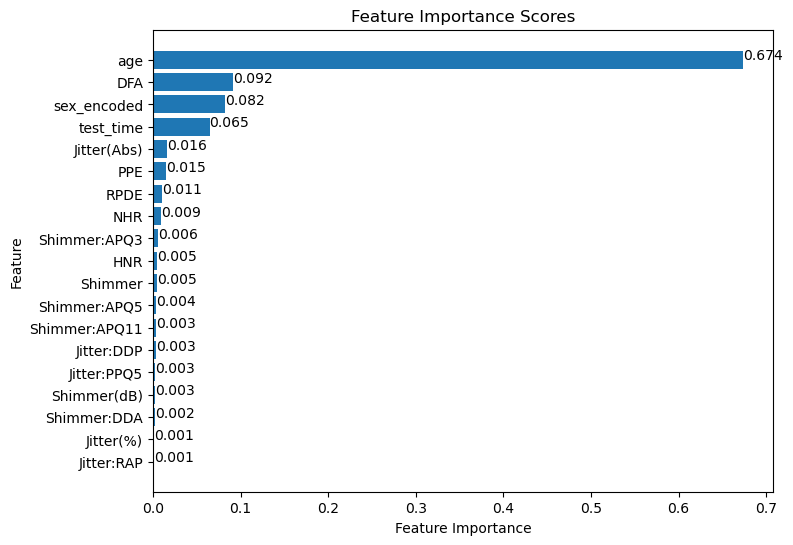

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve importance scores
importances = random_forest_reg.feature_importances_

# Get sorted indices (ascending)
indices = np.argsort(importances)

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
bar_plot = plt.barh(range(len(x_feature_names)), importances[indices], align='center')
plt.yticks(range(len(x_feature_names)), [x_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Scores')

# Annotate bar widths
for rect in bar_plot:
    width = rect.get_width()
    plt.annotate(f'{width:.3f}', xy=(width, rect.get_y() + rect.get_height() / 2))

plt.show()


The importance values of features reflect their contribution to the overall predictive ability of the model.\
A higher importance value indicates that the feature has a greater impact on the prediction, whereas a lower value means the feature has less influence on the prediction.\
By analyzing these importance values, we can understand which features are considered important decision factors by the model.\
In this example, `age` is identified as the most important decision-making factor.